In [31]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, BinaryCrossEntropyLoss, CrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 型の定義
n, s = Ty('n'), Ty('s')

# 言語モデルのロード
#nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("en_core_web_lg")

In [32]:
df = pd.read_csv("/Users/horiuchiminori/Desktop/研究/datasets/travel_dataset/three_class_dataset_ovr_with_label.csv")

In [ ]:
unique_texts = df['text'].unique()
print(len(unique_texts))  # ユニークな文の数
print(unique_texts)       # ユニークな文そのもの

In [5]:
df.head(5)

,text,label,flight,hotel,restaurant
0,Please book a table at an Italian restaurant.,restaurant,0,0,1
1,Can you suggest good restaurants in Kyoto?,restaurant,0,0,1
2,Can you check flight availability for New York?,flight,1,0,0
3,I want to book a flight to Tokyo.,flight,1,0,0
4,I need to reschedule my flight to Paris.,flight,1,0,0


In [33]:
# 型の割り当て
def assign_types(doc):
    pregroup_types = {}
    doc = nlp(sentence)
    # トークン化
    tokens = [token.text for token in doc]

    # ROOTとそれに繋がる名詞（主語・目的語）のみ、dep関係をリストに格納
    dependencies = []
    for token in doc:
        if token.dep_ == 'ROOT':
            pregroup_types[token.text] = s
            dependencies.append((token.text, token.head.text))
        elif token.pos_ in ['NOUN','PRON', 'ADJ', 'ADP', 'VERB']: # 前置詞ひろう
            if token.head.dep_ == 'ROOT':
                pregroup_types[token.text] = n
                dependencies.append((token.text, token.head.text))
            if token.dep_ == 'conj': # 並列に対応させる
                if token.head.head.dep_ == 'ROOT': # 無理矢理２つまで対応
                    pregroup_types[token.text] = n
                    dependencies.append((token.text, token.head.head.text)) # ROOTとつなげる
            if token.dep_ == 'pobj': # 前置詞がついた目的後拾う
                if token.head.head.dep_ == 'ROOT':
                    pregroup_types[token.text] = n
                    dependencies.append((token.text, token.head.text))
            # if token.dep_ == 'dobj':
                # if token.head.head.dep_ == 'ROOT':
                    # pregroup_types[token.text] = n
                    # dependencies.append((token.text, token.head.text))

    # dep関係による型の割り当て（dep関係リストに基づき、dep相手との語順で場合分け）
    for token in doc:
        for dep in dependencies:
            if token.text == dep[1]:
                idx1 = tokens.index(dep[0])
                idx2 = tokens.index(dep[1])
                if pregroup_types[dep[0]] == n:
                    if idx1 < idx2:
                        pregroup_types[token.text] = n.r @ pregroup_types[token.text]
                    else:
                        pregroup_types[token.text] = pregroup_types[token.text] @ n.l
    
    return pregroup_types

In [34]:
# diagram作成
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # cupsの適用
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

In [35]:
train_df, test_df = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=0)
train_sentences = train_df['text']
#train_labels = train_df['label']
test_sentences = test_df['text']
#test_labels = test_df['label']

In [36]:
def onehot_to_2x2(row):
    x = row[['flight', 'hotel', 'restaurant']].values
    x_padded = np.pad(x, (0, 4 - len(x)))
    return x_padded.reshape(2, 2)

train_labels = [onehot_to_2x2(row) for _, row in train_df.iterrows()]
test_labels = [onehot_to_2x2(row) for _, row in test_df.iterrows()]

In [47]:
train_sentences

520     Can you suggest good restaurants in Kyoto?
798       I need to reschedule my flight to Paris.
667            Can you recommend hotels in London?
41        I need to reschedule my flight to Paris.
439     I’d like to reserve a hotel room in Osaka.
                           ...                    
452       I need to reschedule my flight to Paris.
1003             I want to book a flight to Tokyo.
1085    Can you suggest good restaurants in Kyoto?
1008      I need to reschedule my flight to Paris.
178       I need to reschedule my flight to Paris.
Name: text, Length: 1200, dtype: object

In [48]:
train_labels

[array([[0, 0],
        [1, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[0, 1],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[0, 1],
        [0, 0]], dtype=object),
 array([[0, 0],
        [1, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[0, 0],
        [1, 0]], dtype=object),
 array([[0, 1],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[0, 1],
        [0, 0]], dtype=object),
 array([[0, 1],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[0, 1],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=object),
 array([[1, 0],
        [0, 0]], dtype=o

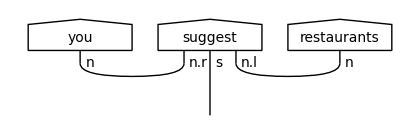

In [56]:
# 各データセットのdiagram化
train_diagrams = []
test_diagrams = []

for sentence in train_sentences:
    train_diagrams.append(create_diagram(sentence))

for sentence in test_sentences:
    test_diagrams.append(create_diagram(sentence))

# チェック用
#for d in range(len(train_sentences)):
    #draw(train_diagrams[d])
train_diagrams[0].draw(figsize=(4, 4))

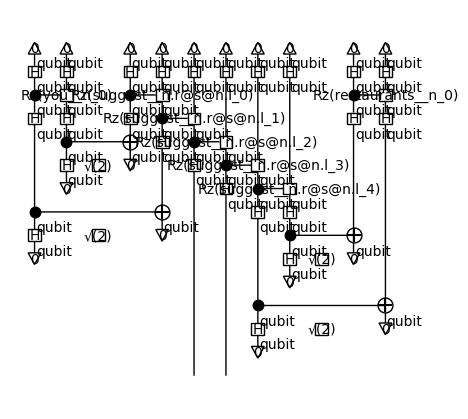

In [ ]:
# 量子回路設計
ansatz = IQPAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 2}, n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

# チェック用
train_circuits[0].draw(figsize=(4, 4))

In [50]:
from lambeq import NumpyModel
all_circuits = train_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [51]:
from lambeq.training import CELoss4, CELoss8
ce = CELoss4(use_jax=True)

In [41]:
def acc(y_hat, y):
        ptrue= []
        for s  in range(len(y)):
            s0=y[s,0,0]
            s1=y[s,0,1]
            s2=y[s,1,0]
            s3=y[s,1,1]
            ptrue.append(np.array([s0, s1, s2, s3]))
            
        qtrue=np.array(ptrue)
 
        ppredic= [ ]
        for s in range(len(y_hat)):
            p0=y_hat[s,0,0]
            p1=y_hat[s,0,1]
            p2=y_hat[s,1,0]
            p3=y_hat[s,1,1]
            q0=abs(p0)**2
            q1=abs(p1)**2
            q2=abs(p2)**2
            q3=abs(p3)**2
            qq=q0+q1+q2+q3
            q0n=q0/qq
            q1n=q1/qq
            q2n=q2/qq
            q3n=q3/qq
            ppredic.append(np.array([q0n,q1n,q2n,q3n]))
        
        ppre=np.array(ppredic)
    
        Error=0.0
        
        for s  in range(len(y)):
            p=(ppre[s,0]-qtrue[s,0])**2+(ppre[s,1]-qtrue[s,1])**2+(ppre[s,2]-qtrue[s,2])**2+(ppre[s,3]-qtrue[s,3])**2
            #p=numpy.dot(ppre[s,:], ptrue[s,:])
            Error= Error+p
            Error=Error/len(y)
            AC=1.0-Error

        return AC

In [ ]:
BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 50
SEED = 0

trainer = QuantumTrainer(
    model,
    loss_function=ce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

from lambeq import Dataset

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [53]:
trainer.fit(train_dataset, val_dataset, log_interval=50)

KeyboardInterrupt: 

Test accuracy: 0.9999999988295601


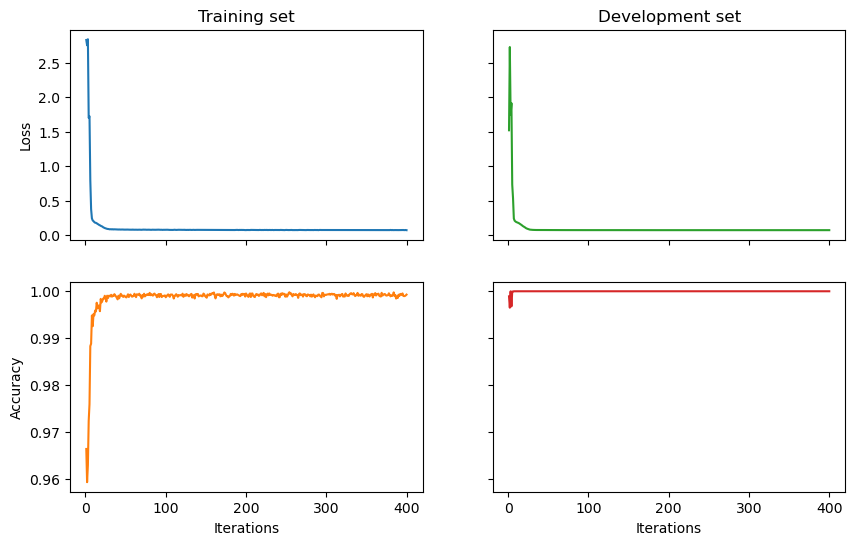

In [44]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)